# Principal Component Analysis (PCA)

Data is one of the main drivers behind most of Machine Learning applications. Analysing the data prior to any usage is of crucial importance, because data can be complicated and it may be challenging to understand what it all means and which parts are actually important.

Dimensionality reduction is a technique which helps us gain a better macro-level understanding of the data by reducing the number of features of a dataset such that only the most important parts are left.

Principal Component Analysis (PCA) is a simple yet powerful technique used for dimensionality reduction. Through it, we can directly decrease the number of feature variables, thereby narrowing down the important features and saving on computations. From a high-level view PCA has three main steps:

- Compute the **covariance matrix** of the data
- Compute the **eigen values** and **vectors** of this covariance matrix
- Use the eigen values and vectors to select only the most important feature vectors, and then transform your data onto those vectors for **reduced dimensionality**.


<img src="Figures/PCA_example.jpg" alt = "PCA" title=" " width = "550" height = "300"/>

If you are interested to know more about the PCA steps, check [this](https://plot.ly/python/v3/ipython-notebooks/principal-component-analysis/) useful tutorial in NumPy.


The entire process will be illustrated in the script below, where we download weather data using [Meteonorm](https://meteonorm.com/en/download).
Meteonorm is a software that collects accurate weather data and representative typical years for any place on earth. You can choose from more than 30 different weather parameters. The DEMO version allows us to download data for only 5 cities in 2005: Bern, Johannesburg, San Francisco, Perth and Brasilia.

The data is stored in comma-separated files called *city*-hour.dat. 
Here we have selected the following 7 main weather parameters:
- Global radiation ($W/m^2$)
- Diffuse radiation ($W/m^2$)
- Temperature ($°C$)
- Wind speed ($m/s$)
- Relative humidity ($\%$)
- Cloud cover ($oktas$)
- Precipitation ($mm$)

**NOTE** In meteorology, an okta is a unit of measurement used to describe the amount of cloud cover. 
SKC = Sky clear (0 oktas); FEW = Few (1 to 2 oktas); SCT = Scattered (3 to 4 oktas); BKN = Broken (5 to 7 oktas); OVC = Overcast (8 oktas)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df1 = pd.read_table('./weather-data/Bern-hour.dat', sep=',', header=None)
df2 = pd.read_table('./weather-data/Johannesburg-hour.dat', sep=',', header=None)
df3 = pd.read_table('./weather-data/SanFrancisco-hour.dat', sep=',', header=None)
df4 = pd.read_table('./weather-data/Perth-hour.dat', sep=',', header=None)
df5 = pd.read_table('./weather-data/Brasilia-hour.dat', sep=',', header=None)

**create_dataframe()** is a function that assigns names to the imported dataset's columns and creates a DateTimeIndex for better manipulation of the time-series data. The function also creates and additional **class** column to distinguish each city for the PCA analysis.

In [3]:
def create_dataframe(dataframe, cls):
    
    import datetime as dt
    
    dataframe.columns = ['year', 'month', 'day', 'hour', 'global radiation', 'diffuse radiation', 
                         'temp', 'wind speed','relative humidity', 'cloud cover', 'precipitation']
    
    datetime = dataframe.loc[:, 'year':'hour']
    
    # the original data has hours in the 1 --> 24 format, but datetime accepts only 0 --> 23
    datetime['hour'] = datetime['hour'] - 1
    
    datetime['DateTime'] = datetime.apply(lambda row: dt.datetime(row.year, row.month, row.day, row.hour), axis=1)
    datetime['DateTime'] = pd.to_datetime(datetime.DateTime)
    dataframe.index = pd.DatetimeIndex(datetime.DateTime)
    
    # include the class column for each city
    dataframe['class'] = np.full(shape=dataframe.shape[0], fill_value=cls)
    
    # delete the first four columns, they are not needed now that there is a DateTimeIndex
    dataframe = dataframe.drop(['year', 'month', 'day', 'hour'], axis=1)
    
    return dataframe


In [4]:
df_bern = create_dataframe(df1, cls=0)
df_perth = create_dataframe(df4, cls=1)
df_johannesburg = create_dataframe(df2, cls=2)
df_sanfrancisco = create_dataframe(df3, cls=3)
df_brasilia = create_dataframe(df5, cls=4)

## 1. Applying PCA to two cities

As an example, we have decided to apply the PCA to the cities of Perth and Bern, since they belong to the Southern and Northern hemisphere, respectively. Owing to the tilt of Earth's rotation relative to the Sun and the ecliptic plane, the seasons are basically inverted between the two hemispheres. 

Therefore, we expect to find clear differences in weather data by extracting only the four months in which is winter in Bern and summer in Perth, i.e. January, February, November and December. 

In [5]:
# we can take the desired period by dropping the months in the middle (i.e. March to October)

df_perth_summer = df_perth.drop(df_perth.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)

df_perth_summer

,global radiation,diffuse radiation,temp,wind speed,relative humidity,cloud cover,precipitation,class
DateTime,,,,,,,,
2005-01-01 00:00:00,0,0,24.7,3.3,68,0,0.0,1
2005-01-01 01:00:00,0,0,23.7,2.8,73,0,0.0,1
2005-01-01 02:00:00,0,0,23.1,3.3,70,0,0.0,1
2005-01-01 03:00:00,0,0,22.5,3.6,76,0,0.0,1
2005-01-01 04:00:00,0,0,22.0,2.6,75,0,0.0,1
...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,1,1,23.7,6.9,47,1,0.0,1
2005-12-31 20:00:00,0,0,21.1,6.0,61,1,0.0,1
2005-12-31 21:00:00,0,0,18.5,4.2,75,1,0.0,1


In [7]:
df_bern_winter = df_bern.drop(df_bern.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)

df_bern_winter

,global radiation,diffuse radiation,temp,wind speed,relative humidity,cloud cover,precipitation,class
DateTime,,,,,,,,
2005-01-01 00:00:00,0,0,3.1,0.5,82,8,2.9,0
2005-01-01 01:00:00,0,0,3.4,0.2,77,8,0.3,0
2005-01-01 02:00:00,0,0,3.1,0.1,77,8,0.4,0
2005-01-01 03:00:00,0,0,3.1,0.4,77,8,0.1,0
2005-01-01 04:00:00,0,0,3.0,0.4,63,8,0.0,0
...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,0,0,1.9,0.5,63,8,0.0,0
2005-12-31 20:00:00,0,0,1.7,0.2,60,8,0.0,0
2005-12-31 21:00:00,0,0,1.5,0.0,76,8,0.2,0


In [8]:
df_pca = pd.concat([df_bern_winter, df_perth_summer], keys=['Bern','Perth'], axis=0, join='inner')

df_pca

global radiation  diffuse radiation  temp  \
      DateTime                                                         
Bern  2005-01-01 00:00:00                 0                  0   3.1   
      2005-01-01 01:00:00                 0                  0   3.4   
      2005-01-01 02:00:00                 0                  0   3.1   
      2005-01-01 03:00:00                 0                  0   3.1   
      2005-01-01 04:00:00                 0                  0   3.0   
...                                     ...                ...   ...   
Perth 2005-12-31 19:00:00                 1                  1  23.7   
      2005-12-31 20:00:00                 0                  0  21.1   
      2005-12-31 21:00:00                 0                  0  18.5   
      2005-12-31 22:00:00                 0                  0  16.0   
      2005-12-31 23:00:00                 0                  0  13.4   

                           wind speed  relative humidity  cloud cover  \
      DateTime                                                          
Bern  2005-01-01 00:00:00         0.5                 82            8   
      2005-01-01 01:00:00         0.2                 77            8   
      2005-01-01 02:00:00         0.1                 77            8   
      2005-01-01 03:00:00         0.4                 77            8   
      2005-01-01 04:00:00         0.4                 63            8   
...                               ...                ...          ...   
Perth 2005-12-31 19:00:00         6.9                 47            1   
      2005-12-31 20:00:00         6.0                 61            1   
      2005-12-31 21:00:00         4.2                 75            1   
      2005-12-31 22:00:00         3.5                 83            1   
      2005-12-31 23:00:00         3.5                100            1   

                           precipitation  class  
      DateTime                                   
Bern  2005-01-01 00:00:00            2.9      0  
      2005-01-01 01:00:00            0.3      0  
      2005-01-01 02:00:00            0.4      0  
      2005-01-01 03:00:00            0.1      0  
      2005-01-01 04:00:00            0.0      0  
...                                  ...    ...  
Perth 2005-12-31 19:00:00            0.0      1  
      2005-12-31 20:00:00            0.0      1  
      2005-12-31 21:00:00            0.0      1  
      2005-12-31 22:00:00            0.0      1  
      2005-12-31 23:00:00            0.0      1  

[5760 rows x 8 columns]

First, we take all the weather parameters (X) as inputs to the PCA algorithm. The target (y) is the city identifier, *class*.

In [9]:
X = df_pca.loc[:, 'global radiation':'precipitation'].values
y = df_pca.loc[:, 'class'].values

PCA returns a sub-space that maximizes the variance along the feature vectors. Therefore, in order to properly measure the variance of those feature vectors, they must be equally balanced. To do this, we first normalise our data to have zero-mean and unit-variance such that each feature will be weighted equally in our calculations. 

This is done by using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) module in **scikit-learn**.

In [10]:
# the data is scaled 

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

scikit-learn implements a built-in module for the PCA that transforms the input data via the *fit_transform()* method. You can specify the desired number of principal components or you can take the ones that hold most of the variance (or information) about the dataset. Normally, the first 2 or 3 principal components are sufficient.

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
Y = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)



[0.50115394 0.17166543 0.13596841 0.08312551 0.05264011 0.03358018
 0.02186641]


Although being two very different cities, the first two eigenvectors contain around 67% of the variance, which is not enough to clearly characterise Bern and Perth. 

Here is an example of how the data looks like for the first principal component (the y-axis does not have a physical meaning, as we are considering just one principal component)

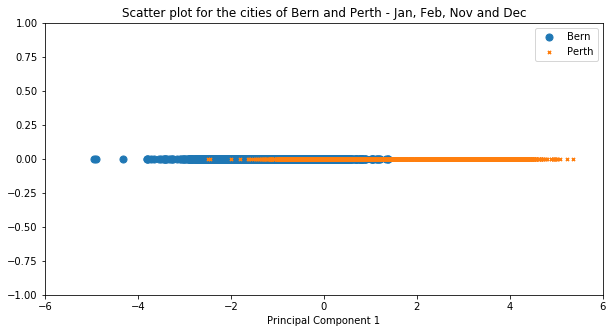

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(Y[:, 0][y == 0], np.zeros((Y[y == 0].shape[0], 1)), marker='o', s=50, label='Bern')
ax.scatter(Y[:, 0][y == 1], np.zeros((Y[y == 1].shape[0], 1)), marker='x', s=10, label='Perth')

ax.set_xlim([-6, 6])
ax.set_ylim([-1, 1])

ax.set_xlabel('Principal Component 1')
ax.set_title('Scatter plot for the cities of Bern and Perth - Jan, Feb, Nov and Dec')
plt.legend()
plt.show()

You can see that there is a big overlap between the two classes (cities). 

**[TO DO]:** What happens if you plot the first two principal components?

In [13]:
###########################
# Task: 
#   Scatterplot with the first two principal components
###########################


### to be completed


#########

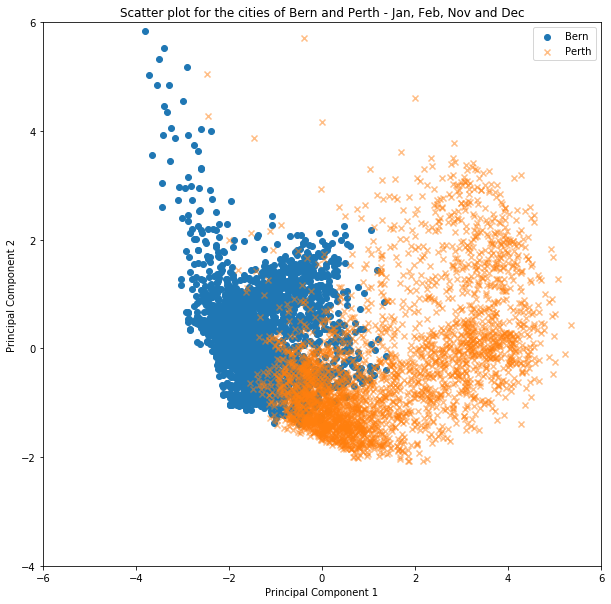

In [14]:
######### TO DELETE

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(Y[:, 0][y == 0], Y[:, 1][y == 0], marker='o', label='Bern')
ax.scatter(Y[:, 0][y == 1], Y[:, 1][y == 1], marker='x', alpha=0.5, label='Perth')

ax.set_xlim([-6, 6])
ax.set_ylim([-4, 6])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Scatter plot for the cities of Bern and Perth - Jan, Feb, Nov and Dec')
plt.legend()
plt.show()

**[Optional]:** Try to make a 3-D scatterplot using the three principal components

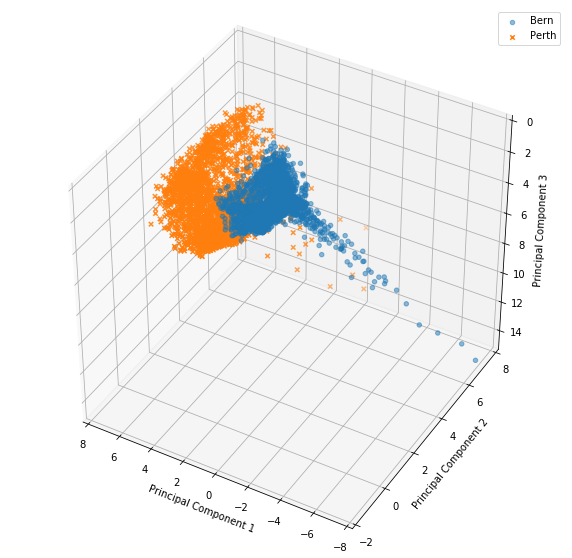

In [15]:
# TO BE COMPLETED

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:, 0][y == 0], Y[:, 1][y == 0], Y[:, 2][y == 0], marker='o', alpha=0.5, label='Bern')
ax.scatter(Y[:, 0][y == 1], Y[:, 1][y == 1], Y[:, 2][y == 1], marker='x', label='Perth')

ax.set_xlim([-8, 8])
ax.set_ylim([-2, 8])
ax.set_zlim([0, 15])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.view_init(-140, 60)
plt.legend()
plt.show()

## 2. CHALLENGE


Try to extend the PCA analysis to all the 5 cities provided in this Notebook splitting the data 

In [18]:
df_sanfrancisco_winter = df_sanfrancisco.drop(df_sanfrancisco.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)
df_johannesburg_winter = df_johannesburg.drop(df_johannesburg.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)
df_brasilia_winter = df_brasilia.drop(df_brasilia.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)

In [19]:
df_tot = pd.concat([df_bern_winter, df_perth_summer, df_johannesburg_winter, df_sanfrancisco_winter, df_brasilia_winter],
                   keys=['Bern','Perth', 'Johannesburg', 'San Francisco', 'Brasilia'], axis=0, join='inner')

df_tot

global radiation  diffuse radiation  temp  \
         DateTime                                                         
Bern     2005-01-01 00:00:00                 0                  0   3.1   
         2005-01-01 01:00:00                 0                  0   3.4   
         2005-01-01 02:00:00                 0                  0   3.1   
         2005-01-01 03:00:00                 0                  0   3.1   
         2005-01-01 04:00:00                 0                  0   3.0   
...                                        ...                ...   ...   
Brasilia 2005-12-31 19:00:00                 0                  0  21.5   
         2005-12-31 20:00:00                 0                  0  20.6   
         2005-12-31 21:00:00                 0                  0  19.7   
         2005-12-31 22:00:00                 0                  0  18.8   
         2005-12-31 23:00:00                 0                  0  17.9   

                              wind speed  relative humidity  cloud cover  \
         DateTime                                                          
Bern     2005-01-01 00:00:00         0.5                 82            8   
         2005-01-01 01:00:00         0.2                 77            8   
         2005-01-01 02:00:00         0.1                 77            8   
         2005-01-01 03:00:00         0.4                 77            8   
         2005-01-01 04:00:00         0.4                 63            8   
...                                  ...                ...          ...   
Brasilia 2005-12-31 19:00:00         1.6                 88            8   
         2005-12-31 20:00:00         1.2                 87            7   
         2005-12-31 21:00:00         0.3                 88            7   
         2005-12-31 22:00:00         0.1                 95            7   
         2005-12-31 23:00:00         0.4                 98            7   

                              precipitation  class  
         DateTime                                   
Bern     2005-01-01 00:00:00            2.9      0  
         2005-01-01 01:00:00            0.3      0  
         2005-01-01 02:00:00            0.4      0  
         2005-01-01 03:00:00            0.1      0  
         2005-01-01 04:00:00            0.0      0  
...                                     ...    ...  
Brasilia 2005-12-31 19:00:00            0.0      4  
         2005-12-31 20:00:00            0.0      4  
         2005-12-31 21:00:00            0.0      4  
         2005-12-31 22:00:00            0.2      4  
         2005-12-31 23:00:00            0.0      4  

[14400 rows x 8 columns]

In [21]:
X = df_tot.loc[:, 'global radiation':'precipitation'].values
y = df_tot.loc[:, 'class'].values

X_std = StandardScaler().fit_transform(X)
pca = PCA()
Y = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)


[0.41925415 0.18870065 0.13915808 0.10103805 0.07218137 0.0571544
 0.02251331]


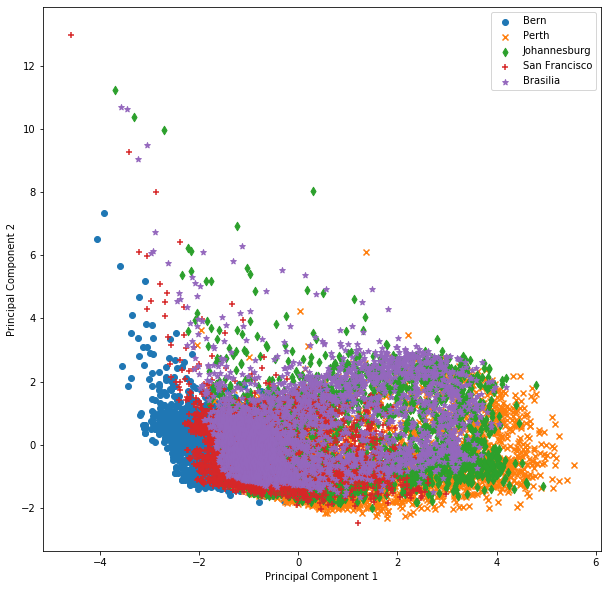

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(Y[:, 0][y == 0], Y[:, 1][y == 0], marker='o', label='Bern')
ax.scatter(Y[:, 0][y == 1], Y[:, 1][y == 1], marker='x', label='Perth')
ax.scatter(Y[:, 0][y == 2], Y[:, 1][y == 2], marker='d', label='Johannesburg')
ax.scatter(Y[:, 0][y == 3], Y[:, 1][y == 3], marker='+', label='San Francisco')
ax.scatter(Y[:, 0][y == 4], Y[:, 1][y == 4], marker='*', label='Brasilia')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend()
plt.show()